In [1]:
import networkx as nx # 图数据挖掘

# 数据分析
import pandas as pd
import numpy as np

import random # 随机数
from tqdm import tqdm # 进度条

# 数据可视化
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签  
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

In [2]:
df = pd.read_csv("p_net_all_4448min.csv")

In [3]:
df.head()

,fromNode,toNode,weight
0,AACS,ABALON,0.298026
1,AACS,ABCA3,0.291654
2,AACS,ABCC3,0.284964
3,AACS,ABCE1,0.332665
4,AACS,ABHD17AP6,0.288316


In [4]:
df.shape

(2076049, 3)

In [5]:
G = nx.from_pandas_edgelist(df, "fromNode", "toNode", edge_attr=True, create_using=nx.Graph())

In [6]:
# 节点个数
len(G)

4448

In [7]:
def get_randomwalk(node, path_length):
    '''
    输入起始节点和路径长度，生成随机游走节点序列
    '''
    
    random_walk = [node]
    
    for i in range(path_length-1):
        # 汇总邻接节点
        temp = list(G.neighbors(node))
        temp = list(set(temp) - set(random_walk))    
        if len(temp) == 0:
            break
        # 从邻接节点中随机选择下一个节点
        random_node = random.choice(temp)
        random_walk.append(random_node)
        node = random_node
        
    return random_walk

In [8]:
all_nodes = list(G.nodes())

In [9]:
#生成随机游走序列

In [10]:
gamma = 150 # 每个节点作为起始点生成随机游走序列个数
walk_length = 10 # 随机游走序列最大长度

In [11]:
random_walks = []

for n in tqdm(all_nodes): # 遍历每个节点
    for i in range(gamma): # 每个节点作为起始点生成gamma个随机游走序列
        random_walks.append(get_randomwalk(n, walk_length))

100%|██████████| 4448/4448 [11:57<00:00,  6.20it/s]


In [12]:
# 生成随机游走序列个数
len(random_walks)

667200

In [13]:
#训练Word2Vec模型

In [14]:
from gensim.models import Word2Vec # 自然语言处理

In [15]:
model = Word2Vec(vector_size=8, # Embedding维数
                 window=4, # 窗口宽度
                 sg=1, # Skip-Gram
                 hs=0, # 不加分层softmax
                 negative=10, # 负采样
                 alpha=0.03,  # 初始学习率
                 min_alpha=0.0001, # 最小学习率
                 epochs=5, # 迭代次数
                 seed=14 # 随机数种子
                )

In [16]:
# 用随机游走序列构建词汇表
model.build_vocab(random_walks, progress_per=2)

In [17]:
# 训练（耗时1分钟左右）
model.train(random_walks, total_examples=model.corpus_count, epochs=100, report_delay=1)

(667180400, 667180400)

In [18]:
X=model.wv.vectors

In [19]:
# 将Embedding用PCA降维到2维
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
embed_2d = pca.fit_transform(X)

In [20]:
embed_2d.shape

(4448, 2)

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

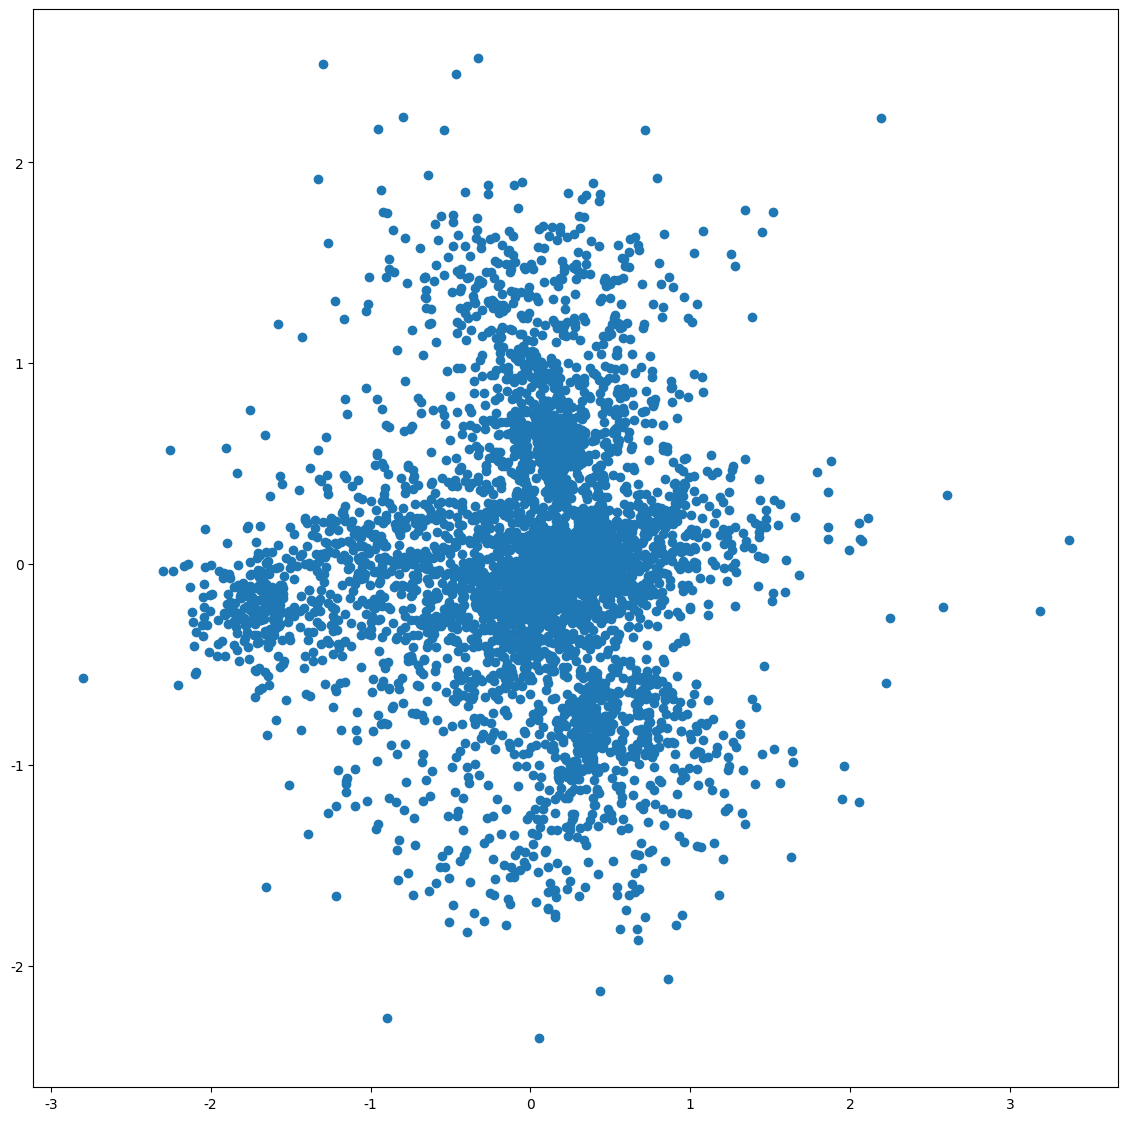

In [21]:
plt.figure(figsize=(14,14))
plt.scatter(embed_2d[:, 0], embed_2d[:, 1])
plt.show()

In [22]:
#TSNE降维可视化
#可视化全部词条的二维Embedding

In [23]:
# 将Embedding用TSNE降维到2维
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, n_iter=500)
embed_2d = tsne.fit_transform(X)

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

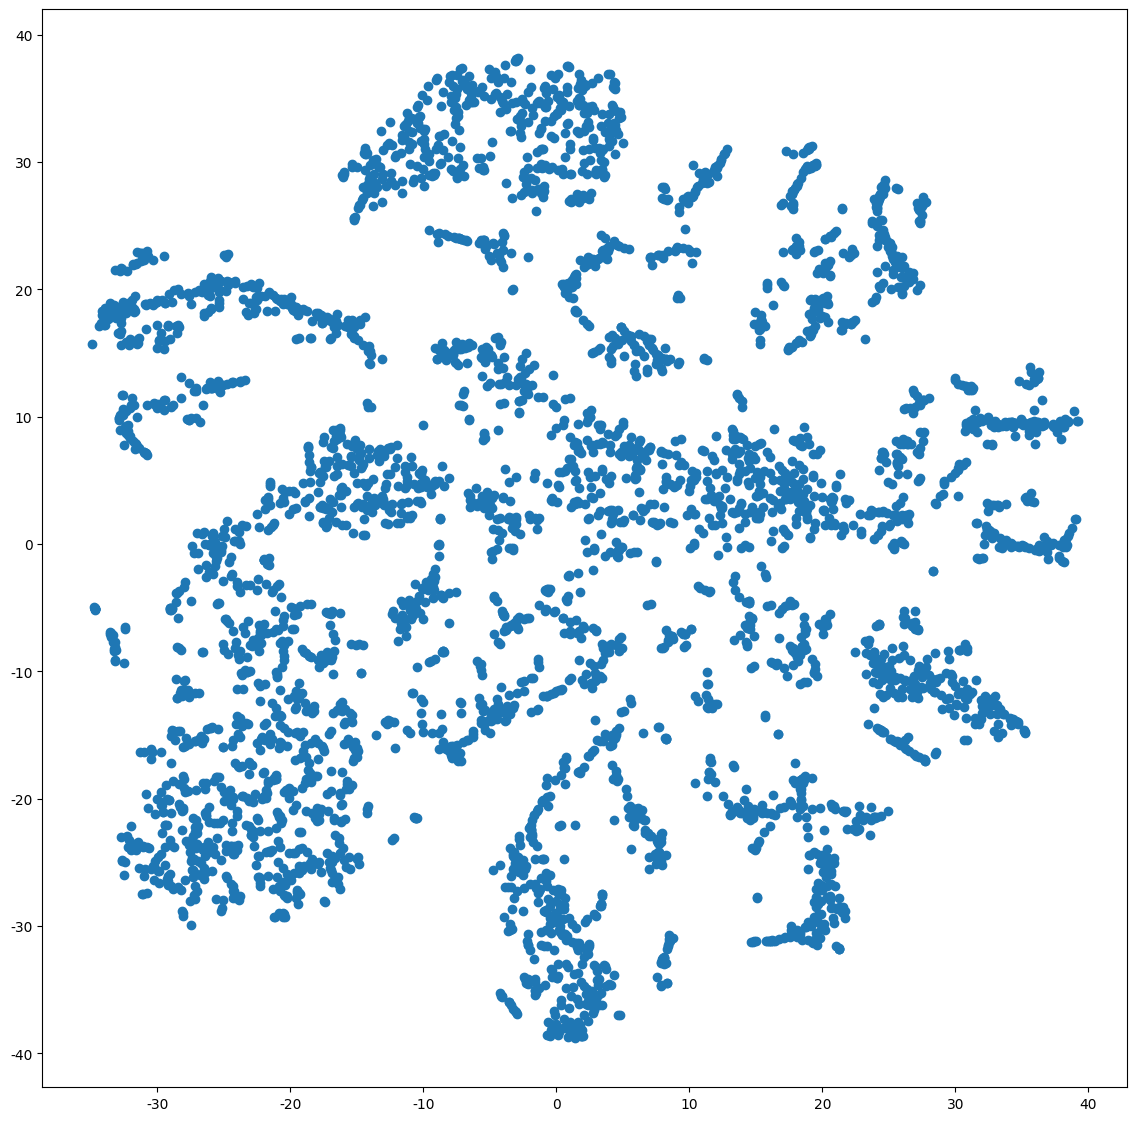

In [24]:
plt.figure(figsize=(14,14))
plt.scatter(embed_2d[:, 0], embed_2d[:, 1])
plt.show()

In [25]:
# 假设你已经完成了Word2Vec模型的训练，并得到了节点的新特征表示 X
X = model.wv.vectors
# 数据标准化
emb=X
eps = 1e-5
mu = np.mean(emb,axis = 0)
sigma = np.std(emb,axis = 0)
tmp = (emb - mu) / (sigma + eps)

In [26]:
import csv


# 获取节点列表
nodes = list(model.wv.index_to_key)

# 构建节点-特征字典
node_features = {node: features for node, features in zip(nodes, tmp)}

# 指定要保存的文件路径和名称
file_path = "deep_walk_node_features_8.csv"

# 将节点及其对应的新特征保存为CSV文件
with open(file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # 写入表头，即特征的列名
    writer.writerow(['Node'] + ['Feature{}'.format(i+1) for i in range(len(node_features[nodes[0]]))])
    
    # 写入每个节点及其对应的新特征
    for node, features in node_features.items():
        writer.writerow([node] + features.tolist())


In [27]:
similarity_matrix =np.corrcoef(tmp)

In [28]:
similarity_matrix

array([[ 1.        ,  0.86623314,  0.25120495, ..., -0.28371974,
         0.31137622, -0.19370081],
       [ 0.86623314,  1.        ,  0.30270817, ..., -0.33396248,
         0.39643952, -0.20744109],
       [ 0.25120495,  0.30270817,  1.        , ...,  0.46162354,
         0.55518091,  0.52278063],
       ...,
       [-0.28371974, -0.33396248,  0.46162354, ...,  1.        ,
         0.12088971,  0.29091088],
       [ 0.31137622,  0.39643952,  0.55518091, ...,  0.12088971,
         1.        ,  0.62121585],
       [-0.19370081, -0.20744109,  0.52278063, ...,  0.29091088,
         0.62121585,  1.        ]])

In [31]:
import pandas as pd 
import numpy as np
sim = pd.read_csv('deepwalk_8_sim_p.csv', index_col=0)  # 使用行名作为索引
Cluster = pd.read_csv('deepwalk_8_cluster_54.csv', index_col=0)  # 使用行名作为索引
Cluster = Cluster['x'].values.astype(np.int32)

In [32]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# 计算轮廓系数
silhouette = silhouette_score(1-sim,Cluster)

# 计算Calinski-Harabasz指数
calinski_harabasz = calinski_harabasz_score(1-sim,Cluster)

# 计算Davies-Bouldin指数
davies_bouldin = davies_bouldin_score(1-sim, Cluster)

print("Silhouette Score:", silhouette)
print("Calinski-Harabasz Index:", calinski_harabasz)
print("Davies-Bouldin Index:", davies_bouldin)

Silhouette Score: 0.20761370092011783
Calinski-Harabasz Index: 439.75175900570144
Davies-Bouldin Index: 1.3458301420606205


In [33]:
similarity_matrix=sim

In [34]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import numpy as np
kmeans = KMeans(n_clusters=54,random_state=111)
clusters = kmeans.fit_predict(1-similarity_matrix)

# 计算轮廓系数
silhouette = silhouette_score(similarity_matrix, clusters)

# 计算Calinski-Harabasz指数
calinski_harabasz = calinski_harabasz_score(similarity_matrix, clusters)

# 计算Davies-Bouldin指数
davies_bouldin = davies_bouldin_score(similarity_matrix, clusters)

print("Silhouette Score:", silhouette)
print("Calinski-Harabasz Index:", calinski_harabasz)
print("Davies-Bouldin Index:", davies_bouldin)

/home/data/t150339/miniconda3/envs/zongjin/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.2409880056167594
Calinski-Harabasz Index: 522.8274593100141
Davies-Bouldin Index: 1.2524442144040875


In [35]:
from collections import Counter
counter = Counter(clusters)

for element, count in counter.items():
    print(f"Cluster {element} has {count} occurrences")

Cluster 26 has 116 occurrences
Cluster 35 has 98 occurrences
Cluster 50 has 60 occurrences
Cluster 40 has 117 occurrences
Cluster 34 has 147 occurrences
Cluster 4 has 85 occurrences
Cluster 1 has 121 occurrences
Cluster 53 has 109 occurrences
Cluster 36 has 50 occurrences
Cluster 38 has 50 occurrences
Cluster 0 has 197 occurrences
Cluster 32 has 66 occurrences
Cluster 23 has 101 occurrences
Cluster 14 has 81 occurrences
Cluster 33 has 103 occurrences
Cluster 48 has 128 occurrences
Cluster 6 has 57 occurrences
Cluster 9 has 93 occurrences
Cluster 10 has 121 occurrences
Cluster 17 has 75 occurrences
Cluster 51 has 57 occurrences
Cluster 24 has 64 occurrences
Cluster 18 has 198 occurrences
Cluster 15 has 47 occurrences
Cluster 25 has 101 occurrences
Cluster 2 has 41 occurrences
Cluster 45 has 51 occurrences
Cluster 16 has 90 occurrences
Cluster 31 has 90 occurrences
Cluster 8 has 81 occurrences
Cluster 13 has 52 occurrences
Cluster 22 has 87 occurrences
Cluster 41 has 87 occurrences
Clust

In [36]:
#谱聚类
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
# 使用谱聚类进行聚类
n_clusters = 54  # 聚类的数量

clustering_model = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
clusters_SC = clustering_model.fit_predict(similarity_matrix)
# 计算轮廓系数
silhouette = silhouette_score(similarity_matrix, clusters_SC)

# 计算Calinski-Harabasz指数
calinski_harabasz = calinski_harabasz_score(similarity_matrix, clusters_SC)

# 计算Davies-Bouldin指数
davies_bouldin = davies_bouldin_score(similarity_matrix, clusters_SC)

print("Silhouette Score:", silhouette)
print("Calinski-Harabasz Index:", calinski_harabasz)
print("Davies-Bouldin Index:", davies_bouldin)

/home/data/t150339/miniconda3/envs/zongjin/lib/python3.8/site-packages/sklearn/cluster/_spectral.py:688: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Silhouette Score: 0.19342097043587894
Calinski-Harabasz Index: 439.4030527758758
Davies-Bouldin Index: 1.2569264507908313


In [37]:
from collections import Counter
counter = Counter(clusters_SC)

for element, count in counter.items():
    print(f"Cluster {element} has {count} occurrences")

Cluster 49 has 140 occurrences
Cluster 12 has 168 occurrences
Cluster 5 has 176 occurrences
Cluster 2 has 241 occurrences
Cluster 53 has 192 occurrences
Cluster 9 has 68 occurrences
Cluster 31 has 131 occurrences
Cluster 46 has 62 occurrences
Cluster 28 has 87 occurrences
Cluster 17 has 82 occurrences
Cluster 51 has 123 occurrences
Cluster 6 has 134 occurrences
Cluster 8 has 106 occurrences
Cluster 4 has 146 occurrences
Cluster 14 has 76 occurrences
Cluster 50 has 68 occurrences
Cluster 48 has 58 occurrences
Cluster 3 has 161 occurrences
Cluster 26 has 72 occurrences
Cluster 1 has 26 occurrences
Cluster 7 has 42 occurrences
Cluster 19 has 94 occurrences
Cluster 42 has 34 occurrences
Cluster 10 has 84 occurrences
Cluster 30 has 86 occurrences
Cluster 25 has 54 occurrences
Cluster 45 has 51 occurrences
Cluster 15 has 34 occurrences
Cluster 32 has 44 occurrences
Cluster 35 has 59 occurrences
Cluster 43 has 16 occurrences
Cluster 20 has 85 occurrences
Cluster 0 has 100 occurrences
Cluster 